In [1]:
# Install Ultralytics YOLO package
!pip install ultralytics

# Install OpenCV for image processing
!pip install opencv-python-headless

# Matplotlib is usually pre-installed in Colab, but you can install it if needed
!pip install matplotlib
# OpenCV for image processing

# Pillow (PIL) for image handling
!pip install Pillow

# NumPy (usually pre-installed on Colab)
!pip install numpy

# IPython for interactive widgets and display (should already be installed)
!pip install ipython
# Install PaddleOCR and its dependencies
!pip install paddlepaddle paddleocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.6/544.6 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.5 MB/s eta 0:00:00
   ━━━

<IPython.core.display.Javascript object>

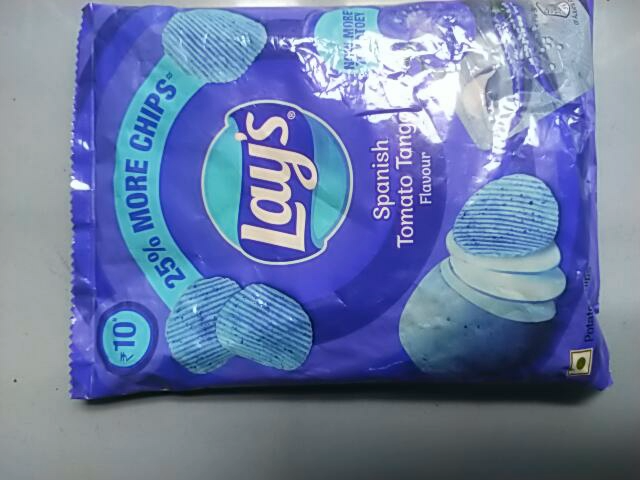

Image saved to: /content/captured_image.png


In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
import PIL
from io import BytesIO
from google.colab.patches import cv2_imshow

# JavaScript to display the webcam feed and add a 'Capture' button
def js_capture_image():
    js = Javascript('''
    async function captureImage() {
        // Check if video and button elements already exist, if so, remove them
        const existingVideo = document.querySelector('video');
        const existingButton = document.querySelector('button');
        if (existingVideo) existingVideo.remove();
        if (existingButton) existingButton.remove();

        // Create video and button elements
        const video = document.createElement('video');
        const button = document.createElement('button');
        button.textContent = 'Capture';

        // Append video and button to the page
        document.body.appendChild(video);
        document.body.appendChild(button);

        // Set up webcam stream
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        video.style.width = '320px';
        await new Promise((resolve) => video.onloadedmetadata = resolve);
        video.play();

        // Wait for the 'Capture' button to be clicked
        await new Promise((resolve) => button.onclick = resolve);

        // Capture the image from the video stream
        const canvas = document.createElement('canvas');
        const context = canvas.getContext('2d');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        context.drawImage(video, 0, 0, canvas.width, canvas.height);

        // Stop the webcam and remove the video and button elements
        stream.getTracks().forEach(track => track.stop());
        video.remove();
        button.remove();

        // Return the captured image data
        return canvas.toDataURL('image/png');
    }
    captureImage();
    ''')
    display(js)

# Function to decode image and convert it to OpenCV format
def get_image():
    image_data = eval_js('captureImage()')
    image_bytes = b64decode(image_data.split(',')[1])
    image = np.array(PIL.Image.open(BytesIO(image_bytes)))
    return image

# Trigger the capture image process
js_capture_image()
image = get_image()

# Show the captured image
cv2_imshow(image)

# Save the image to /content/ (Colab file explorer section)
image_path = '/content/captured_image.png'
cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Display a message confirming the saved image path
print(f"Image saved to: {image_path}")

In [5]:
# Import necessary libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR

# Initialize PaddleOCR model
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Set language as English

# Step 1: Load the YOLO model (either pretrained or your trained model)
model_trained = YOLO('/content/brand_type (1).pt')  # Path to your trained model

# Step 2: Define the path to the test image
image_path = '/content/captured_image.png'

# Step 3: Perform inference using the trained YOLO model
results_trained = model_trained.predict(source=image_path, conf=0.25)

# Step 4: Extract brand name text using PaddleOCR from YOLO bounding boxes, and group by class labels
def extract_text_grouped_by_class(image_path, results):
    # Load the image
    img = cv2.imread(image_path)

    # Dictionary to store grouped text for each class
    grouped_text = {}

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].int().tolist()  # Bounding box coordinates
            class_id = int(box.cls[0])  # Class ID
            class_name = result.names[class_id]  # Class name

            # Crop the bounding box area from the image
            cropped_img = img[y1:y2, x1:x2]

            # Use PaddleOCR to detect text in the cropped area
            ocr_result = ocr.ocr(cropped_img, cls=True)

            # Extract detected text
            for line in ocr_result[0]:
                text = line[1][0]  # Extracting the text part

                # Group the text by class
                if class_name in grouped_text:
                    grouped_text[class_name] += " " + text  # Concatenate if the class already exists
                else:
                    grouped_text[class_name] = text  # Initialize the class with the first text

    return grouped_text

# Step 5: Extract grouped text from bounding boxes
grouped_texts = extract_text_grouped_by_class(image_path, results_trained)

# Print the grouped text with class names
print("Extracted Text from Bounding Boxes with Class Names:")
for class_name, text in grouped_texts.items():
    print(f"{class_name} : {text}")

# Optional: Visualize the YOLO detection with bounding boxes
def visualize_results(image_path, results, title=""):
    # Load the image using OpenCV
    img = cv2.imread(image_path)

    # Draw bounding boxes and labels
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].int().tolist()  # Bounding box coordinates
            conf = box.conf[0]  # Confidence score
            label = f'{result.names[int(box.cls[0])]} {conf:.2f}'  # Class label and confidence

            # Draw rectangle and put the label on the image
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Convert image to RGB for displaying in matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')  # Hide axes
    plt.show()

# Visualize the YOLO results (Optional)
visualize_results(image_path, results_trained, title="Trained Model Results with Bounding Boxes")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


ModuleNotFoundError: No module named 'paddleocr'

In [ ]:
!pip install paddleocr